In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import pytensor.tensor.subtensor as st
from itertools import combinations

%load_ext lab_black

# 9. Simvastatin*

This one is about factorial designs (2-way ANOVA) with sum-to-zero and corner constraints.

Adapted from [Unit 7: simvastatin.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/simvastatin.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/simvastatin_data.txt).

Thanks to [Anthony Miyaguchi](https://github.com/acmiyaguchi) for updating this example!

In a quantitative physiology lab II at Georgia Tech, students were asked to find a therapeutic model to test on MC3T3-E1 cell line to enhance osteoblastic growth. The students found a drug called Simvastatin, a cholesterol lowering drug to test on these cells. Using a control and three different concentrations, $10^{-9}$, $10^{-8}$ and $10^{-7}$ M, cells were treated with the drug. These cells were plated on four, 24 well plates with each well plate having a different treatment. To test for osteoblastic differentiation an assay, pNPP, was used to test for alkaline phosphatase activity. The higher the alkaline phosphatase activity the better the cells are differentiating, and become more bone like. This assay was performed 6 times total within 11 days. Each time the assay was performed, four wells from each plate were used.


## Notes: 

A [good explanation](https://stats.stackexchange.com/questions/257778/sum-to-zero-constraint-in-one-way-anova) of STZ constraints.


In [12]:
data = pd.read_csv("../data/simvastatin_data.tsv", sep="\t")
data.head(3)

apa  conc  time
0  0.062     1     1
1  0.517     1     1
2  0.261     1     1

In [3]:
# set up alternate coordinates, the ID3 or clusters column
conc_idx, conc = pd.factorize(data["conc"])
time_idx, time = pd.factorize(data["time"])
coords = {"conc": conc, "time": time, "id": data.index}

conc_idx, time_idx, coords

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
        1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
        0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5]),
 {'conc': Int64Index([1, 2, 3, 4], dtype='int64'),
  'time': Int64Index([1, 2, 3, 4, 5, 6], dtype='int64'),
  'id': RangeIndex(start=0, stop=96, step=1)})

## Model 1 with sum-to-zero constraints

In [4]:
def differences(var, index):
    """Calculate differences between levels with names like "alpha[low] - alpha[high]".

    var: aesara.tensor.var.TensorVariable
    index: pandas.Index
    """
    name = var.name
    for i, j in combinations(range(index.size), 2):
        a, b = index[i], index[j]
        pm.Deterministic(f"{name}[{a}] - {name}[{b}]", var[i] - var[j])


with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # sum-to-zero constraints
    # sets the first element of a dimension to the negative sum of the rest
    sst_1d_0 = lambda var: st.set_subtensor(var[0], -var[1:].sum(axis=0))
    sst_2d_0 = lambda var: st.set_subtensor(var[0, :], -var[1:, :].sum(axis=0))
    sst_2d_1 = lambda var: st.set_subtensor(var[:, 0], -var[:, 1:].sum(axis=1))

    alpha = pm.Deterministic("alpha", sst_1d_0(_alpha), dims="conc")
    beta = pm.Deterministic("beta", sst_1d_0(_beta), dims="time")
    _alphabeta = sst_2d_1(_alphabeta)
    alphabeta = pm.Deterministic(
        "alphabeta", sst_2d_0(_alphabeta), dims=("conc", "time")
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data, dims="id")

    # calculate differences between levels with appropriate names
    differences(alpha, coords["conc"])
    differences(beta, coords["time"])

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


In [5]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

mean     sd  hdi_3%  hdi_97%
mu0                   0.239  0.025   0.192    0.286
tau                  17.233  2.874  12.020   22.775
sigma                 0.243  0.021   0.206    0.283
alpha[1]              0.049  0.043  -0.033    0.130
alpha[2]              0.068  0.044  -0.014    0.149
alpha[3]             -0.075  0.043  -0.153    0.008
alpha[4]             -0.042  0.042  -0.121    0.037
beta[1]               0.046  0.055  -0.058    0.149
beta[2]              -0.150  0.055  -0.258   -0.047
beta[3]              -0.019  0.055  -0.118    0.090
beta[4]               0.230  0.055   0.123    0.329
beta[5]              -0.022  0.056  -0.129    0.081
beta[6]              -0.086  0.057  -0.190    0.023
alphabeta[1, 1]      -0.085  0.097  -0.267    0.099
alphabeta[1, 2]      -0.083  0.096  -0.265    0.095
alphabeta[1, 3]      -0.210  0.098  -0.393   -0.028
alphabeta[1, 4]       0.501  0.095   0.316    0.673
alphabeta[1, 5]      -0.019  0.097  -0.207    0.160
alphabeta[1, 6]      -0.104  0.096  -0.276    0.081
alphabeta[2, 1]       0.150  0.097  -0.027    0.338
alphabeta[2, 2]      -0.100  0.097  -0.283    0.081
alphabeta[2, 3]       0.354  0.097   0.173    0.535
alphabeta[2, 4]      -0.176  0.095  -0.362   -0.003
alphabeta[2, 5]      -0.187  0.094  -0.358   -0.006
alphabeta[2, 6]      -0.042  0.098  -0.225    0.141
alphabeta[3, 1]      -0.043  0.098  -0.226    0.140
alphabeta[3, 2]       0.056  0.097  -0.119    0.241
alphabeta[3, 3]      -0.046  0.097  -0.228    0.133
alphabeta[3, 4]      -0.138  0.096  -0.310    0.051
alphabeta[3, 5]       0.158  0.094  -0.020    0.335
alphabeta[3, 6]       0.013  0.098  -0.171    0.198
alphabeta[4, 1]      -0.022  0.095  -0.196    0.158
alphabeta[4, 2]       0.126  0.094  -0.056    0.301
alphabeta[4, 3]      -0.098  0.095  -0.283    0.076
alphabeta[4, 4]      -0.187  0.097  -0.353    0.012
alphabeta[4, 5]       0.048  0.095  -0.132    0.223
alphabeta[4, 6]       0.133  0.095  -0.047    0.311
alpha[1] - alpha[2]  -0.019  0.071  -0.156    0.112
alpha[1] - alpha[3]   0.125  0.069  -0.004    0.258
alpha[1] - alpha[4]   0.092  0.069  -0.034    0.226
alpha[2] - alpha[3]   0.144  0.071   0.010    0.275
alpha[2] - alpha[4]   0.111  0.070  -0.021    0.241
alpha[3] - alpha[4]  -0.033  0.069  -0.164    0.098
beta[1] - beta[2]     0.195  0.086   0.041    0.365
beta[1] - beta[3]     0.064  0.086  -0.100    0.224
beta[1] - beta[4]    -0.185  0.086  -0.343   -0.019
beta[1] - beta[5]     0.068  0.086  -0.093    0.229
beta[1] - beta[6]     0.131  0.087  -0.028    0.297
beta[2] - beta[3]    -0.131  0.085  -0.292    0.027
beta[2] - beta[4]    -0.380  0.085  -0.542   -0.225
beta[2] - beta[5]    -0.128  0.088  -0.293    0.039
beta[2] - beta[6]    -0.064  0.087  -0.227    0.099
beta[3] - beta[4]    -0.249  0.086  -0.404   -0.088
beta[3] - beta[5]     0.003  0.086  -0.160    0.158
beta[3] - beta[6]     0.067  0.088  -0.093    0.235
beta[4] - beta[5]     0.252  0.086   0.081    0.406
beta[4] - beta[6]     0.316  0.087   0.149    0.475
beta[5] - beta[6]     0.064  0.087  -0.099    0.228

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

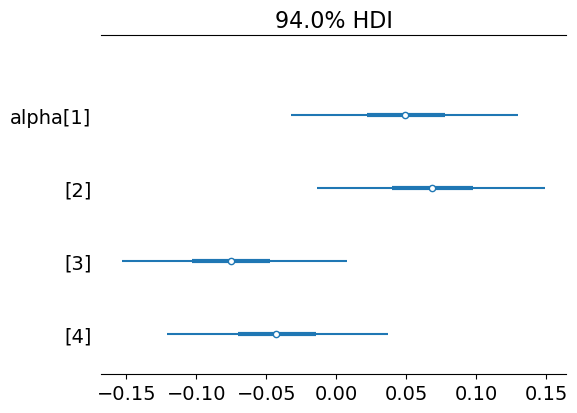

In [6]:
az.plot_forest(trace, var_names=["alpha"], combined=True)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

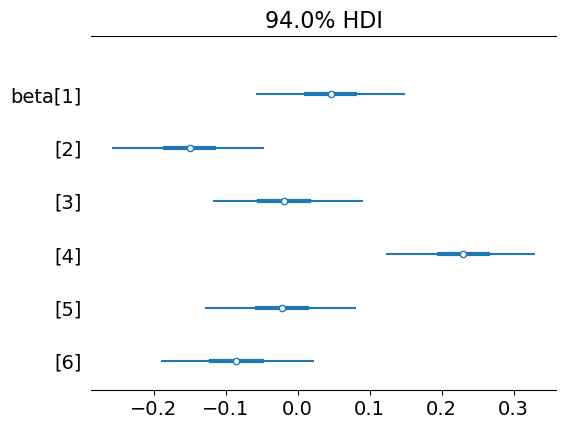

In [7]:
az.plot_forest(trace, var_names=["beta"], combined=True)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

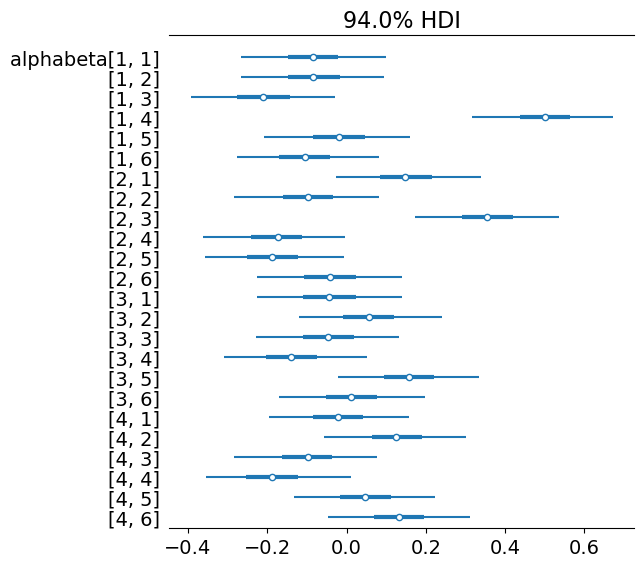

In [8]:
az.plot_forest(trace, var_names=["alphabeta"], combined=True)

## Model 2 with corner constraints

In [9]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # corner constraints: sets the first element of a dimension to zero
    alpha = pm.Deterministic("alpha", st.set_subtensor(_alpha[0], 0), dims="conc")
    beta = pm.Deterministic("beta", st.set_subtensor(_beta[0], 0), dims="time")
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], 0)
    alphabeta = pm.Deterministic(
        "alphabeta", st.set_subtensor(_alphabeta[0, :], 0), dims=("conc", "time")
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data, dims="id")

    differences(alpha, coords["conc"])
    differences(beta, coords["time"])

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


In [10]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

mean     sd  hdi_3%  hdi_97%
mu0                   0.247  0.124   0.007    0.469
tau                  17.120  2.884  11.492   22.201
sigma                 0.244  0.021   0.206    0.282
alpha[1]              0.000  0.000   0.000    0.000
alpha[2]              0.257  0.176  -0.086    0.573
alpha[3]             -0.082  0.173  -0.400    0.243
alpha[4]             -0.025  0.176  -0.355    0.302
beta[1]               0.000  0.000   0.000    0.000
beta[2]              -0.191  0.174  -0.511    0.140
beta[3]              -0.186  0.174  -0.513    0.145
beta[4]               0.771  0.175   0.445    1.100
beta[5]              -0.001  0.175  -0.347    0.309
beta[6]              -0.146  0.177  -0.472    0.195
alphabeta[1, 1]       0.000  0.000   0.000    0.000
alphabeta[1, 2]       0.000  0.000   0.000    0.000
alphabeta[1, 3]       0.000  0.000   0.000    0.000
alphabeta[1, 4]       0.000  0.000   0.000    0.000
alphabeta[1, 5]       0.000  0.000   0.000    0.000
alphabeta[1, 6]       0.000  0.000   0.000    0.000
alphabeta[2, 1]       0.000  0.000   0.000    0.000
alphabeta[2, 2]      -0.256  0.246  -0.708    0.212
alphabeta[2, 3]       0.324  0.248  -0.137    0.787
alphabeta[2, 4]      -0.912  0.246  -1.384   -0.458
alphabeta[2, 5]      -0.406  0.251  -0.880    0.057
alphabeta[2, 6]      -0.180  0.250  -0.656    0.287
alphabeta[3, 1]       0.000  0.000   0.000    0.000
alphabeta[3, 2]       0.096  0.246  -0.370    0.552
alphabeta[3, 3]       0.120  0.244  -0.334    0.583
alphabeta[3, 4]      -0.682  0.248  -1.140   -0.199
alphabeta[3, 5]       0.138  0.245  -0.335    0.586
alphabeta[3, 6]       0.069  0.246  -0.395    0.527
alphabeta[4, 1]       0.000  0.000   0.000    0.000
alphabeta[4, 2]       0.141  0.249  -0.324    0.603
alphabeta[4, 3]       0.045  0.247  -0.428    0.502
alphabeta[4, 4]      -0.753  0.250  -1.230   -0.296
alphabeta[4, 5]      -0.002  0.249  -0.473    0.449
alphabeta[4, 6]       0.166  0.248  -0.283    0.639
alpha[1] - alpha[2]  -0.257  0.176  -0.573    0.086
alpha[1] - alpha[3]   0.082  0.173  -0.243    0.400
alpha[1] - alpha[4]   0.025  0.176  -0.302    0.355
alpha[2] - alpha[3]   0.338  0.176   0.013    0.672
alpha[2] - alpha[4]   0.282  0.175  -0.041    0.619
alpha[3] - alpha[4]  -0.057  0.175  -0.378    0.276
beta[1] - beta[2]     0.191  0.174  -0.140    0.511
beta[1] - beta[3]     0.186  0.174  -0.145    0.513
beta[1] - beta[4]    -0.771  0.175  -1.100   -0.445
beta[1] - beta[5]     0.001  0.175  -0.309    0.347
beta[1] - beta[6]     0.146  0.177  -0.195    0.472
beta[2] - beta[3]    -0.005  0.176  -0.334    0.323
beta[2] - beta[4]    -0.962  0.177  -1.297   -0.637
beta[2] - beta[5]    -0.190  0.175  -0.526    0.127
beta[2] - beta[6]    -0.045  0.176  -0.360    0.308
beta[3] - beta[4]    -0.956  0.173  -1.296   -0.645
beta[3] - beta[5]    -0.185  0.172  -0.515    0.126
beta[3] - beta[6]    -0.040  0.173  -0.363    0.285
beta[4] - beta[5]     0.771  0.175   0.458    1.103
beta[4] - beta[6]     0.916  0.177   0.600    1.264
beta[5] - beta[6]     0.145  0.176  -0.184    0.474

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -p aesara,aeppl

Last updated: Wed Mar 22 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

aesara: 2.8.10
aeppl : 0.1.1

numpy   : 1.24.2
pandas  : 1.5.3
pytensor: 2.10.1
arviz   : 0.14.0
pymc    : 5.1.2

